# Parte 1: Extracción de datos a través de Web Scrapping

## Importar las librerias con las que trabajaremos

In [34]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import csv
import time
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Extraer la fecha actual para la recopilación de los datos

In [3]:

hoy = datetime.today()
fecha_inicio = hoy - timedelta(days=7)
todos_sismos = []
print(hoy)

2025-10-19 19:41:22.400037


- Con esto podemos saber la fecha actual y lo mas importante, el dia en el que estamos, este dato lo utilizaremos para poder extraer los datos de cada dia que queramos de la página web a la que haremos web scrapping

## Creación de estructura repetitiva para la extracción de los datos


In [4]:
for i in range(7):  # Recorre los últimos dias i, si queremos extraer más días, cambiar el rango, 7 para tener datos rapidamente
    fecha = hoy - timedelta(days=i)
    url = f"https://www.sismologia.cl/sismicidad/catalogo/{fecha.year}/{fecha.month:02d}/{fecha.strftime('%Y%m%d')}.html"
    print(f"Extrayendo: {url}")

    resp = requests.get(url)
    if resp.status_code != 200:
        print(f"No se pudo acceder a {url}")
        continue

    soup = BeautifulSoup(resp.text, "html.parser")
    tabla = soup.find("table", class_="sismologia detalle")
    if not tabla:
        print(f"No se encontró tabla para {fecha}")
        continue

    filas = tabla.find_all("tr")[1:] 

    for fila in filas:
        celdas = fila.find_all("td")
        if len(celdas) < 5:
            continue

        fecha_local = celdas[0].get_text(strip=True)
        fecha_utc = celdas[1].get_text(strip=True)
        lat_long_raw = celdas[2].get_text(strip=True)
        lat_long = [x for x in lat_long_raw.replace('\n', ' ').split(' ') if x]
        latitud = lat_long[0] if len(lat_long) > 0 else ""
        longitud = lat_long[1] if len(lat_long) > 1 else ""
        profundidad = celdas[3].get_text(strip=True)
        magnitud = celdas[4].get_text(strip=True)

        todos_sismos.append({
            "fecha_local": fecha_local,
            "fecha_utc": fecha_utc,
            "latitud": latitud,
            "longitud": longitud,
            "profundidad": profundidad,
            "magnitud": magnitud
        })
    time.sleep(1)

Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251019.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251018.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251017.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251016.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251015.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251014.html
Extrayendo: https://www.sismologia.cl/sismicidad/catalogo/2025/10/20251013.html


- De esta extracción obtenemos los siguientes datos. 
1. La fecha local del sismo.
2. El tiempo universal coordinado o UTC
3. La latitud del sismo
4. La longitud del sismo
5. La profundidad del sismo
6. La magnitud de este.
- Con estos datos podemos obtener mucha información respecto a los sismos en Chile, podemos clasificar las regiones por sismos, la cantidad de estos, la potencia (leve, moderada, grave), etc.

## Guardar los datos en almacenados en un CSV

In [5]:

df_sismos = pd.DataFrame(todos_sismos)
df_sismos.to_csv("sismos.csv", index=False, encoding="utf-8")
print(f"Guardado en: sismos.csv")

Guardado en: sismos.csv


- Con esto guardamos toda la información en un CSV, sin embargo al guardar de forma directa se generan errores, por lo que en la siguiente sección nos encargaremos de la correción y limpieza se errores.

# Parte 2: Correción de errores

## Leer el csv con pandas

In [6]:
df = pd.read_csv("sismos.csv", encoding="utf-8")
print(df.head())

                                         fecha_local            fecha_utc  \
0          2025-10-19 18:52:5961 km al SE de Socaire  2025-10-19 21:52:59   
1         2025-10-19 16:35:5139 km al SO de OllagÃ¼e  2025-10-19 19:35:51   
2  2025-10-19 15:50:3741 km al O de San Pedro de ...  2025-10-19 18:50:37   
3            2025-10-19 14:22:5546 km al N de Calama  2025-10-19 17:22:55   
4          2025-10-19 14:06:3424 km al O de OllagÃ¼e  2025-10-19 17:06:34   

          latitud  longitud profundidad magnitud  
0  -24.038-67.550       NaN      245 km   2.9 Ml  
1  -21.540-68.423       NaN      129 km   3.1 Ml  
2  -22.832-68.587       NaN      113 km   2.7 Ml  
3  -22.084-68.783       NaN      100 km   3.1 Ml  
4  -21.196-68.479       NaN      133 km   2.7 Ml  


- Con esta información nos damos cuenta de que la latitud y la longitud se almacenan en la misma variable, debido a que no se separan en la página web

## Arreglar latitud y longitud

In [7]:
for i, fila in df.iterrows():
    if pd.isna(fila["longitud"]) or str(fila["longitud"]).strip() == "":
        latlong = str(fila["latitud"]).strip()
        if "-" in latlong[1:]:  # evitar el primer signo negativo
            partes = latlong[1:].split("-", 1)
            if len(partes) == 2:
                df.at[i, "latitud"] = latlong[0] + partes[0]
                df.at[i, "longitud"] = "-" + partes[1]
print(df.head())

                                         fecha_local            fecha_utc  \
0          2025-10-19 18:52:5961 km al SE de Socaire  2025-10-19 21:52:59   
1         2025-10-19 16:35:5139 km al SO de OllagÃ¼e  2025-10-19 19:35:51   
2  2025-10-19 15:50:3741 km al O de San Pedro de ...  2025-10-19 18:50:37   
3            2025-10-19 14:22:5546 km al N de Calama  2025-10-19 17:22:55   
4          2025-10-19 14:06:3424 km al O de OllagÃ¼e  2025-10-19 17:06:34   

   latitud longitud profundidad magnitud  
0  -24.038  -67.550      245 km   2.9 Ml  
1  -21.540  -68.423      129 km   3.1 Ml  
2  -22.832  -68.587      113 km   2.7 Ml  
3  -22.084  -68.783      100 km   3.1 Ml  
4  -21.196  -68.479      133 km   2.7 Ml  


C:\Users\pcx\AppData\Local\Temp\ipykernel_244\3256924476.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-67.550' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[i, "longitud"] = "-" + partes[1]


- Con esta correción podemos separar las latitudes y longitudes, solo falta guardarlos, en este caso, en un nuevo CSV llamado BDD

## Guardar datos en un csv

In [8]:
df.to_csv("bdd.csv", index=False, encoding="utf-8")

print(f"Archivo corregido guardado como: bdd.csv")

Archivo corregido guardado como: bdd.csv


- Ahora podremos tener todos los datos guardados correctamente y sin fallos, pero se nos presenta un nuevo problema, si nos fijamos en la magnitud, esta no es un numero, si no que un numero mas el tipo de dato (Ml)

## Convertir magnitudes a decimales

In [9]:
df['magnitud'] = (
    df['magnitud']
    .astype(str)
    .str.extract(r'([\d,.]+)')
    .replace(',', '.', regex=True)
    .astype(float)
)
print(df['magnitud'].head())

0    2.9
1    3.1
2    2.7
3    3.1
4    2.7
Name: magnitud, dtype: float64


- Con esto tenemos todas las magnitudes transformadas a float como se indica en dtype

## Solucionar problemas de tipo de dato con longitud

In [10]:
latitudes = []
longitudes = []

for i, fila in df.iterrows():
    lat_s = str(fila["latitud"]) if not pd.isna(fila["latitud"]) else ""
    lon_s = str(fila["longitud"]) if not pd.isna(fila["longitud"]) else ""

    if lon_s.strip() == "" or lon_s.lower() in ("nan", "none"):
        nums = re.findall(r'-?\d+(?:\.\d+)?', lat_s)
        if len(nums) >= 2:
            latitudes.append(nums[0])
            longitudes.append(nums[1])
            continue

    lat_num = re.search(r'-?\d+(?:\.\d+)?', lat_s)
    lon_num = re.search(r'-?\d+(?:\.\d+)?', lon_s)
    latitudes.append(lat_num.group(0) if lat_num else None)
    longitudes.append(lon_num.group(0) if lon_num else None)

df["latitud"] = pd.to_numeric(latitudes, errors="coerce")
df["longitud"] = pd.to_numeric(longitudes, errors="coerce")

print(df[["latitud", "longitud"]].dtypes)
print(df[["latitud", "longitud"]].head())

latitud     float64
longitud    float64
dtype: object
   latitud  longitud
0  -24.038   -67.550
1  -21.540   -68.423
2  -22.832   -68.587
3  -22.084   -68.783
4  -21.196   -68.479


- Con esto nos facilitamos el manejo de estos datos, para la siguiente parte, que es usar los datos para tener información útil que podamos mostrar

# Parte 3: Creación de nuevos datos

- Con los datos obtenidos, podemos crear información nueva que nos sirva para el análisis de datos, en este caso, crearemos tres nuevas columnas región para indicar la región en la que se produjo el sismo (de forma aproximada), enlace a google maps (para que al hacer click, dirija instanteneamente al punto exacto donde se produjo el sismo) y rango profundidad (para la manipulación de datos mas intuitiva y entendible)

## Ubicar aproximadamente los sismos en una región

In [11]:
# Rangos de latitud para cada región (al chile ser un país largo en latitud, podemos usar esto para asignar regiones aproximadas)
rangos_regiones = [
    (-19.000, -17.300, "Arica y Parinacota"),
    (-21.300, -19.000, "Tarapacá"),
    (-25.300, -21.300, "Antofagasta"),
    (-29.300, -25.300, "Atacama"),
    (-32.000, -29.300, "Coquimbo"),
    (-32.950, -32.000, "Valparaíso"),
    (-34.150, -32.950, "Región Metropolitana de Santiago"),
    (-35.000, -34.150, "Libertador B. O'Higgins"),
    (-36.250, -35.000, "Maule"),
    (-36.850, -36.250, "Ñuble"),
    (-37.900, -36.850, "Biobío"),
    (-40.500, -37.900, "La Araucanía"),
    (-40.580, -39.500, "Los Ríos"),
    (-43.600, -40.580, "Los Lagos"),
    (-48.000, -43.600, "Aysén del General Carlos Ibáñez del Campo"),
    (-52.810, -48.000, "Magallanes y de la Antártica Chilena")
]
# Guardar las regiones en una variable
regiones = []

for lat in df["latitud"]:
    region_encontrada = "Fuera de Chile"
    for lat_min, lat_max, region in rangos_regiones:
        if lat_min <= lat <= lat_max:
            region_encontrada = region
            break
    regiones.append(region_encontrada)

df["region"] = regiones
print(df["region"].head())
print(len(df))


0    Antofagasta
1    Antofagasta
2    Antofagasta
3    Antofagasta
4       Tarapacá
Name: region, dtype: object
168


- Con esto ya tenemos asignadas regiones a cada uno de los sismos, pero el centro sismológico nacional también detecta sismos afuera de Chile, por lo que nos desharemos de estos datos que no nos sirven

## Limpieza de regiones Fuera de Chile

In [12]:
df = df[df['region'] != "Fuera de Chile"]
print(df[['latitud', 'longitud', 'region']])
print(f"Datos fuera de Chile eliminados. Total registros: {len(df)}")

     latitud  longitud              region
0    -24.038   -67.550         Antofagasta
1    -21.540   -68.423         Antofagasta
2    -22.832   -68.587         Antofagasta
3    -22.084   -68.783         Antofagasta
4    -21.196   -68.479            Tarapacá
..       ...       ...                 ...
163  -30.698   -71.666            Coquimbo
164  -30.680   -71.768            Coquimbo
165  -30.673   -71.668            Coquimbo
166  -40.811   -75.538           Los Lagos
167  -18.908   -69.257  Arica y Parinacota

[166 rows x 3 columns]
Datos fuera de Chile eliminados. Total registros: 166


## Creación de enlaces para la visualización en google maps

In [13]:
links = []

for i, row in df.iterrows():
    lat = row["latitud"]
    lon = row["longitud"]
    link = f"https://www.google.com/maps?q={lat},{lon}"
    links.append(link)

df["maps_link"] = links
print(df[["latitud", "longitud", "maps_link"]].head())


   latitud  longitud                                      maps_link
0  -24.038   -67.550   https://www.google.com/maps?q=-24.038,-67.55
1  -21.540   -68.423   https://www.google.com/maps?q=-21.54,-68.423
2  -22.832   -68.587  https://www.google.com/maps?q=-22.832,-68.587
3  -22.084   -68.783  https://www.google.com/maps?q=-22.084,-68.783
4  -21.196   -68.479  https://www.google.com/maps?q=-21.196,-68.479


- Ahora al hacer click sobre un enlace cualquiera, tendremos las coordenadas exactas del evento, información útil.

## Limpieza de profundidad y creación de rangos de profundidad

In [27]:
df['profundidad'] = (df['profundidad'].astype(str).str.extract(r'([\d.]+)').astype(float))

bins = [0, 10, 30, 60, 100, 200, 500, np.inf]
labels_profundidad = ['<10 km', '10–30 km', '30–60 km', '60–100 km', '100–200 km', '200–500 km', '>500 km']
df['rango_profundidad'] = pd.cut(df['profundidad'], bins=bins, labels=labels_profundidad)
print(df[['profundidad', 'rango_profundidad']].head())

   profundidad rango_profundidad
0        245.0        200–500 km
1        129.0        100–200 km
2        113.0        100–200 km
3        100.0         60–100 km
4        133.0        100–200 km


- En este caso tuvimos que transformar el tipo de dato de profundidad a un float y luego establecer profundidades para tener de rango, esto es útil ya que nos sirve para mostrar información de los sismos de forma mas clara en los gráficos, ya que mostrar muchas columnas, cada una representando una profundidad diferente solo la hara dificil de entender

## Categorizar magnitudes

In [16]:
bins = [-np.inf, 3.5, 5.0, np.inf]
labels = ['Leve', 'Moderado', 'Fuerte']
df['categoria'] = pd.cut(df['magnitud'], bins=bins, labels=labels)

- Como en el caso de la profundidad es util guardar las magnitudes en intervalos para la facil representación de los datos

## Guardar todo lo trabajado en CSV

In [17]:
df.to_csv('bdd.csv', index=False)

- Con toda la información guardada, ya podemos empezar a trabajar con los datos y convertirlos en información útil

# Parte 4: Transformación de datos

## Conteo de datos por columnas (categoria, region, magnitud)

### Categoria

In [18]:
conteos_categoria = df['categoria'].value_counts().reindex(labels, fill_value=0)
print("Conteos totales por categoría:")
print(conteos_categoria.to_string())

Conteos totales por categoría:
categoria
Leve        135
Moderado     29
Fuerte        2


### Magnitud

In [28]:
conteos_profundidad = df['rango_profundidad'].value_counts().reindex(labels_profundidad, fill_value=0)
print("Conteos por rango de profundidad:")
print(conteos_profundidad.to_string())

Conteos por rango de profundidad:
rango_profundidad
<10 km         2
10–30 km      14
30–60 km      50
60–100 km     25
100–200 km    59
200–500 km    16
>500 km        0


### Categoria por región

In [ ]:
conteos = df.groupby(['region', 'categoria']).size().unstack(fill_value=0)
conteos['Total'] = conteos.sum(axis=1)
conteos = conteos.sort_values('Total', ascending=False)
print("Sismos por región y categoría:")
print(conteos.to_string())

Sismos por región y categoría:
categoria                         Leve  Moderado  Fuerte  Total
region                                                         
Antofagasta                         51         9       0     60
Coquimbo                            26         8       1     35
Tarapacá                            23         6       1     30
Atacama                             13         3       0     16
Libertador B. O'Higgins              6         0       0      6
Valparaíso                           4         1       0      5
Arica y Parinacota                   3         0       0      3
Ñuble                                3         0       0      3
Los Lagos                            1         1       0      2
Región Metropolitana de Santiago     1         1       0      2
Maule                                2         0       0      2
Biobío                               1         0       0      1
La Araucanía                         1         0       0      1


C:\Users\pcx\AppData\Local\Temp\ipykernel_244\1522825040.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteos = df.groupby(['region', 'categoria']).size().unstack(fill_value=0)


### Resumen estadístico de magnitud por región

In [21]:
resumen = df.groupby('region')['magnitud'].agg(['count','mean','std','min','max']).sort_values('count', ascending=False)
print("Resumen estadístico de magnitud por región (top por cantidad):")
print(resumen.head(20).to_string())

Resumen estadístico de magnitud por región (top por cantidad):
                                  count      mean       std  min  max
region                                                               
Antofagasta                          60  3.053333  0.491786  2.3  4.8
Coquimbo                             35  3.257143  0.714672  2.5  5.5
Tarapacá                             30  3.070000  0.695875  2.5  5.6
Atacama                              16  2.956250  0.572676  2.5  4.2
Libertador B. O'Higgins               6  3.050000  0.403733  2.5  3.5
Valparaíso                            5  3.040000  0.378153  2.6  3.6
Arica y Parinacota                    3  2.766667  0.230940  2.5  2.9
Ñuble                                 3  3.000000  0.360555  2.6  3.3
Los Lagos                             2  3.400000  0.282843  3.2  3.6
Región Metropolitana de Santiago      2  3.500000  0.282843  3.3  3.7
Maule                                 2  2.600000  0.000000  2.6  2.6
Biobío                     

### Profundidad por región

In [29]:
conteos = df.groupby(['region', 'rango_profundidad']).size().unstack(fill_value=0)
conteos['Total'] = conteos.sum(axis=1)
conteos = conteos.sort_values('Total', ascending=False)
print("Sismos por región y rango de profundidad:")
print(conteos.to_string())

Sismos por región y rango de profundidad:
rango_profundidad                 <10 km  10–30 km  30–60 km  60–100 km  100–200 km  200–500 km  >500 km  Total
region                                                                                                         
Antofagasta                            2         2         1         10          30          15        0     60
Coquimbo                               0         5        29          0           1           0        0     35
Tarapacá                               0         0         1          8          20           1        0     30
Atacama                                0         2        11          2           1           0        0     16
Libertador B. O'Higgins                0         3         0          1           2           0        0      6
Valparaíso                             0         1         2          1           1           0        0      5
Arica y Parinacota                     0         0         0  

C:\Users\pcx\AppData\Local\Temp\ipykernel_244\2456716096.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteos = df.groupby(['region', 'rango_profundidad']).size().unstack(fill_value=0)


### Resumen estadístico de profundidad por región

In [31]:
resumen = df.groupby('region')['profundidad'].agg(['count','mean','std','min','max']).sort_values('count', ascending=False)
print("Resumen estadístico de profundidad por región (top por cantidad):")
print(resumen.head(20).to_string())

Resumen estadístico de profundidad por región (top por cantidad):
                                  count        mean        std   min    max
region                                                                     
Antofagasta                          60  141.216667  70.070931  10.0  280.0
Coquimbo                             35   40.028571  15.544028  24.0  119.0
Tarapacá                             30  111.600000  28.458803  36.0  218.0
Atacama                              16   51.625000  20.191995  25.0  110.0
Libertador B. O'Higgins               6   71.000000  50.572720  20.0  126.0
Valparaíso                            5   59.600000  39.991249  27.0  110.0
Arica y Parinacota                    3   96.333333  29.771351  62.0  115.0
Ñuble                                 3   78.000000  52.048055  45.0  138.0
Los Lagos                             2   40.500000  33.234019  17.0   64.0
Región Metropolitana de Santiago      2   61.000000  38.183766  34.0   88.0
Maule                 

## Creación de gráficos

### Configuración de estilos

In [35]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

### 1. Gráfico de barras de conteo por categoría

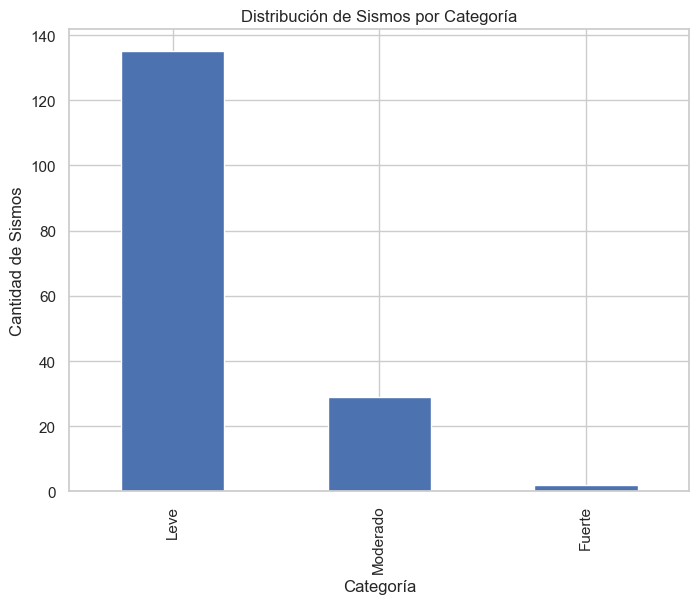

In [36]:
plt.figure(figsize=(8, 6))
bins = [-np.inf, 3.5, 5.0, np.inf]
labels = ['Leve', 'Moderado', 'Fuerte']
df['categoria'] = pd.cut(df['magnitud'], bins=bins, labels=labels)
conteos = df['categoria'].value_counts().reindex(labels)
conteos.plot(kind='bar')
plt.title('Distribución de Sismos por Categoría')
plt.xlabel('Categoría')
plt.ylabel('Cantidad de Sismos')
plt.show()


### 2. Top 10 regiones por cantidad de sismos

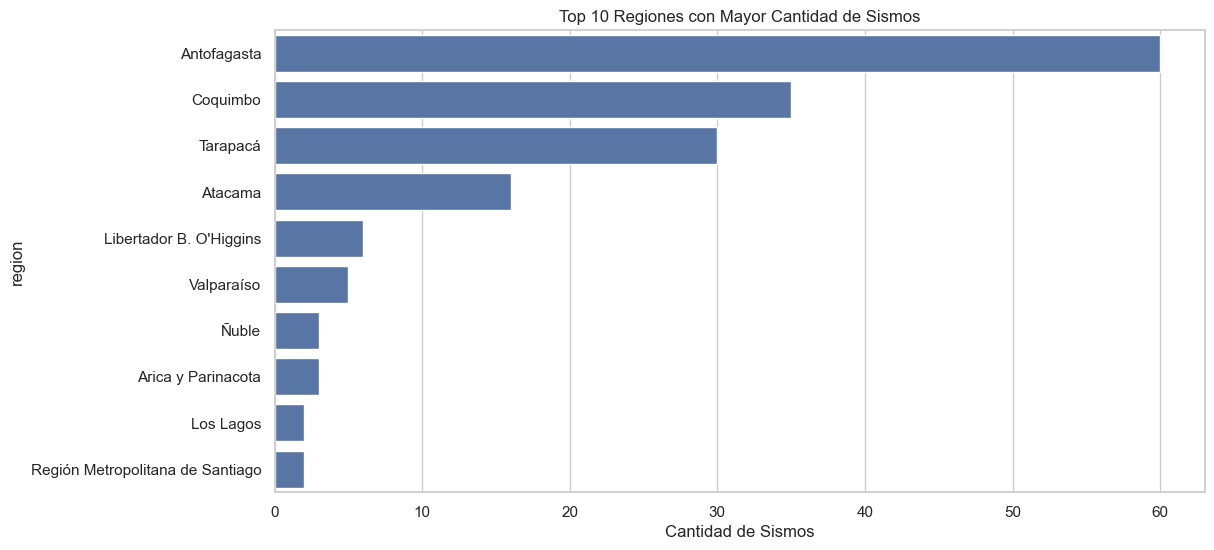

In [37]:
plt.figure(figsize=(12, 6))
top_10_regiones = df['region'].value_counts().head(10)
sns.barplot(x=top_10_regiones.values, y=top_10_regiones.index)
plt.title('Top 10 Regiones con Mayor Cantidad de Sismos')
plt.xlabel('Cantidad de Sismos')
plt.show()

### 3. Distribución de magnitudes (histograma)

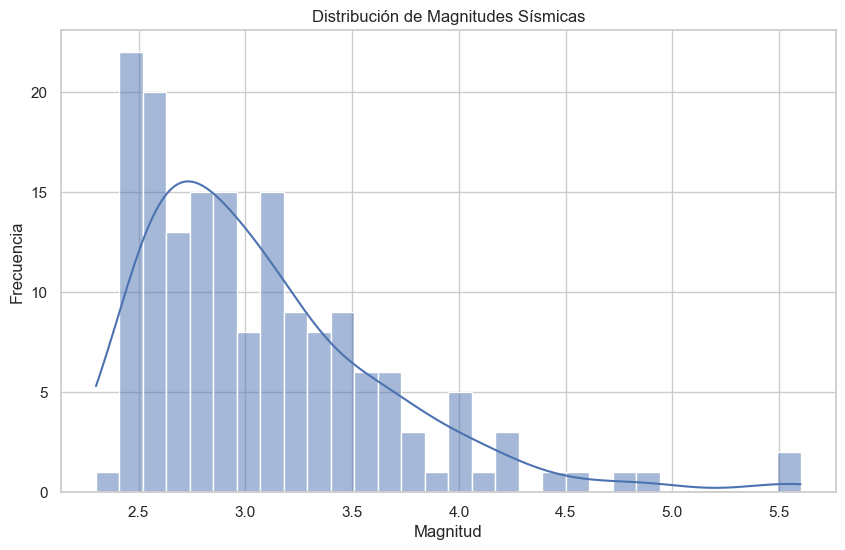

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='magnitud', bins=30, kde=True)
plt.title('Distribución de Magnitudes Sísmicas')
plt.xlabel('Magnitud')
plt.ylabel('Frecuencia')
plt.show()

### 4. Mapa de calor de sismos por región y categoría

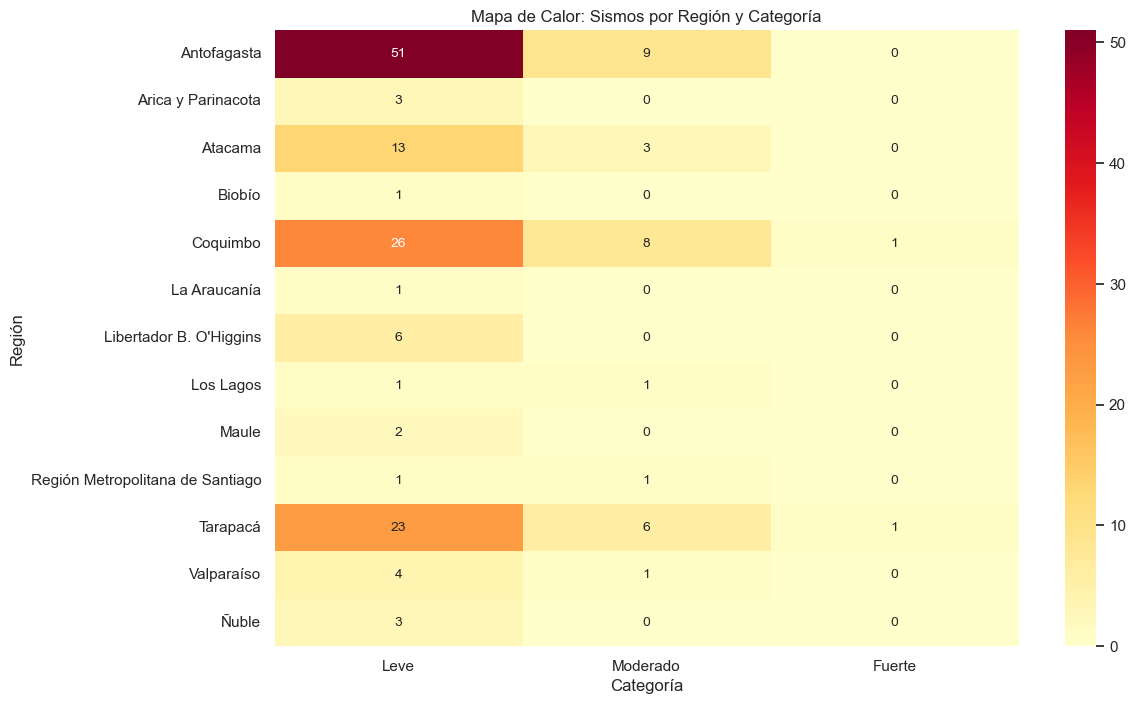

In [39]:
plt.figure(figsize=(12, 8))
pivot_table = pd.crosstab(df['region'], df['categoria'])
sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Mapa de Calor: Sismos por Región y Categoría')
plt.ylabel('Región')
plt.xlabel('Categoría')
plt.show()

### 5. Gráfico de dispersión de magnitud vs profundidad

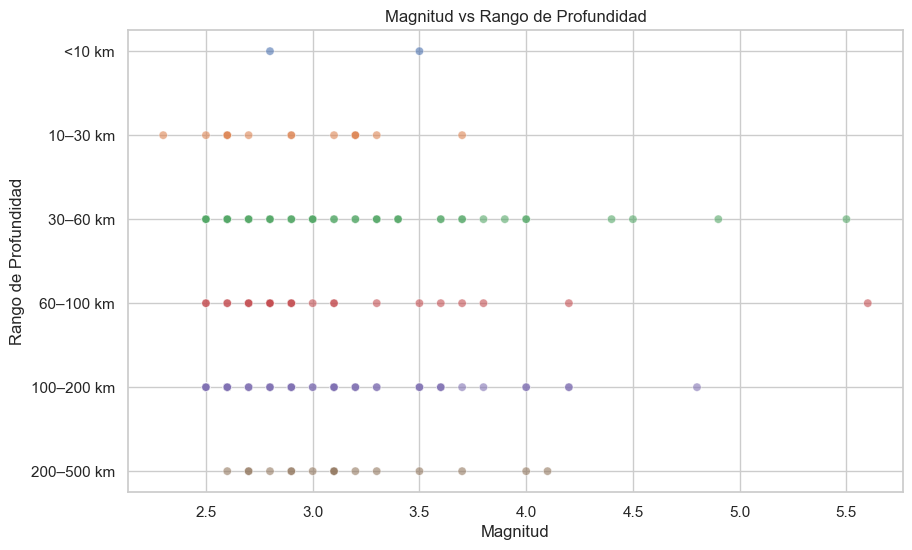

In [40]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='magnitud', y='rango_profundidad', hue='rango_profundidad', alpha=0.6, legend=False)
plt.title('Magnitud vs Rango de Profundidad')
plt.xlabel('Magnitud')
plt.ylabel('Rango de Profundidad')
plt.show()

### 6. Box plot de magnitudes por región

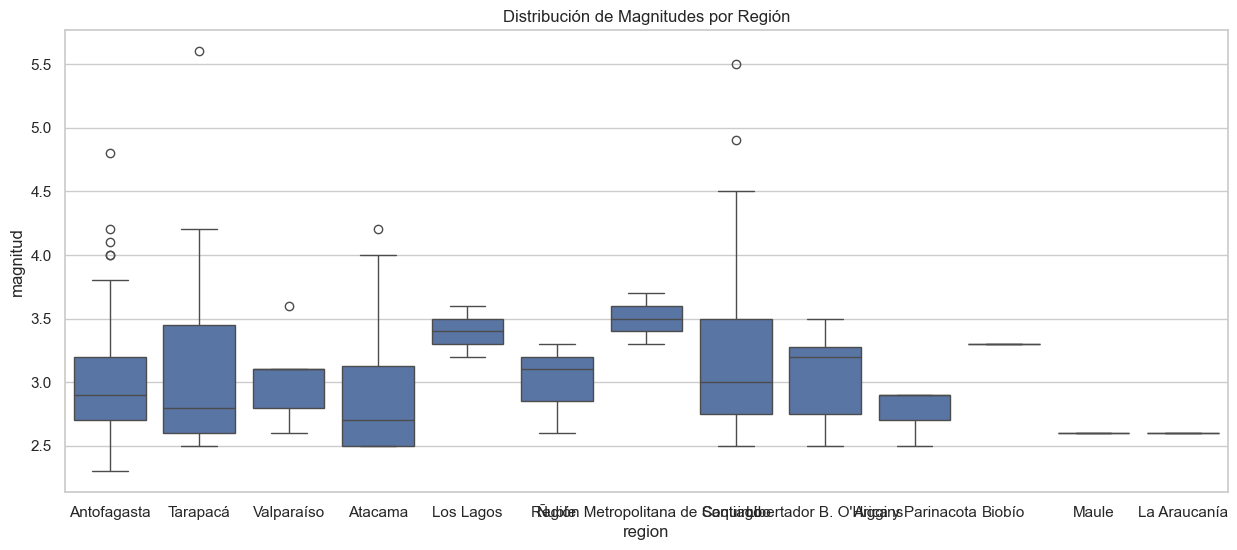

In [41]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='region', y='magnitud')
plt.title('Distribución de Magnitudes por Región')
plt.show()
